# Import

In [1]:
# settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
from IPython.display import HTML, display
from gensim.models.poincare import PoincareModel, PoincareRelations
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from ipywidgets import widgets, interact, interactive

from src.load_datasets import load_dataset, load_rankings
from src.encoding import load_graph

In [3]:
# figure settings
sns.set()
sns.set(style='whitegrid', )
#sns.set_palette(palette="Set2")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(7)

# Get data

In [4]:
dataset = load_dataset('../../data/raw/dataset.csv')
rankings = load_rankings('../../data/raw/rankings.csv')

Loading data ...
Loading rankings ...


# Get graph

In [5]:
# get graph as networkx graph
G = load_graph("../../data/raw/graph.adjlist")
# show some information about the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 45
Number of edges: 44


### Visualize the graph

In [6]:
# create a Pyvis Network instance
nt = Network(heading="Hierarchical Structure Feature Encoder", notebook=True, cdn_resources='in_line')
# add nodes and edges to the Pyvis Network
nt.from_nx(G)
# show the Pyvis Network
html = nt.generate_html('encoder_graph.html')
display(HTML(html))

### Vector representations of those no de labels plotted on a 2d scatter graph

In [7]:
def calculate_level(G):
    """
    Generates the feature hierarchical level for each node in the graph. Where the level defines the depth of the node in the graph hierarchy.

    :param G: The input graph.
    :type G: networkx.Graph

    :return: The graph with the hierarchical level.
    """
    levels = {}  # Dictionary to store hierarchical levels of nodes

    # Iterate over all nodes in the graph and calculate their hierarchical levels
    for node in G.nodes:
        if G.degree(node) == 0:
            levels[node] = 0
        else:
            max_level = 0
            for neighbor in G.neighbors(node):
                if neighbor in levels:
                    max_level = max(max_level, levels[neighbor] + 1)
            levels[node] = max_level

    # Add the hierarchical level as an attribute to each node in the graph
    nx.set_node_attributes(G, levels, "hierarchical_level")

    return G

In [8]:
# Get hierarchical level for each node
G = calculate_level(G)

In [9]:
# Print the hierarchical level for all nodes and make mapping dict
level_dict = {}
for node in G.nodes:
    print(f"Node: {node}, Level: {G.nodes[node]['hierarchical_level']}")
    level_dict[node] = G.nodes[node]['hierarchical_level']

Node: BE, Level: 0
Node: identifier, Level: 1
Node: BUCV10RGLMME, Level: 0
Node: bucvglmm, Level: 1
Node: BUCV10TE, Level: 0
Node: bucvte, Level: 1
Node: BUCV2RGLMME, Level: 2
Node: BUCV2TE, Level: 2
Node: BUCV5RGLMME, Level: 2
Node: BUCV5TE, Level: 2
Node: CBE, Level: 0
Node: supervised, Level: 1
Node: CE, Level: 0
Node: unsupervised, Level: 2
Node: CV10RGLMME, Level: 0
Node: cvglmm, Level: 1
Node: CV10TE, Level: 0
Node: cvte, Level: 1
Node: CV2RGLMME, Level: 2
Node: CV2TE, Level: 2
Node: CV5RGLMME, Level: 2
Node: CV5TE, Level: 2
Node: DE, Level: 3
Node: DTEM10, Level: 0
Node: dte, Level: 2
Node: DTEM2, Level: 3
Node: DTEM5, Level: 3
Node: ME01E, Level: 0
Node: mee, Level: 2
Node: ME10E, Level: 3
Node: ME1E, Level: 3
Node: MHE, Level: 3
Node: OE, Level: 2
Node: OHE, Level: 2
Node: PBTE0001, Level: 0
Node: pbte, Level: 2
Node: PBTE001, Level: 3
Node: PBTE01, Level: 3
Node: RGLMME, Level: 0
Node: glmm, Level: 2
Node: SE, Level: 3
Node: TE, Level: 0
Node: te, Level: 2
Node: WOEE, Level: 

In [10]:
# Get the position of each node in the graph
pos = nx.spring_layout(G, k=0.5, iterations=50)

In [11]:
# Extract x and y coordinates and combine with the level attribute
graph_df = pd.DataFrame.from_dict(pos, orient='index', columns=['x', 'y'])
graph_df['level'] = nx.get_node_attributes(G, 'hierarchical_level')

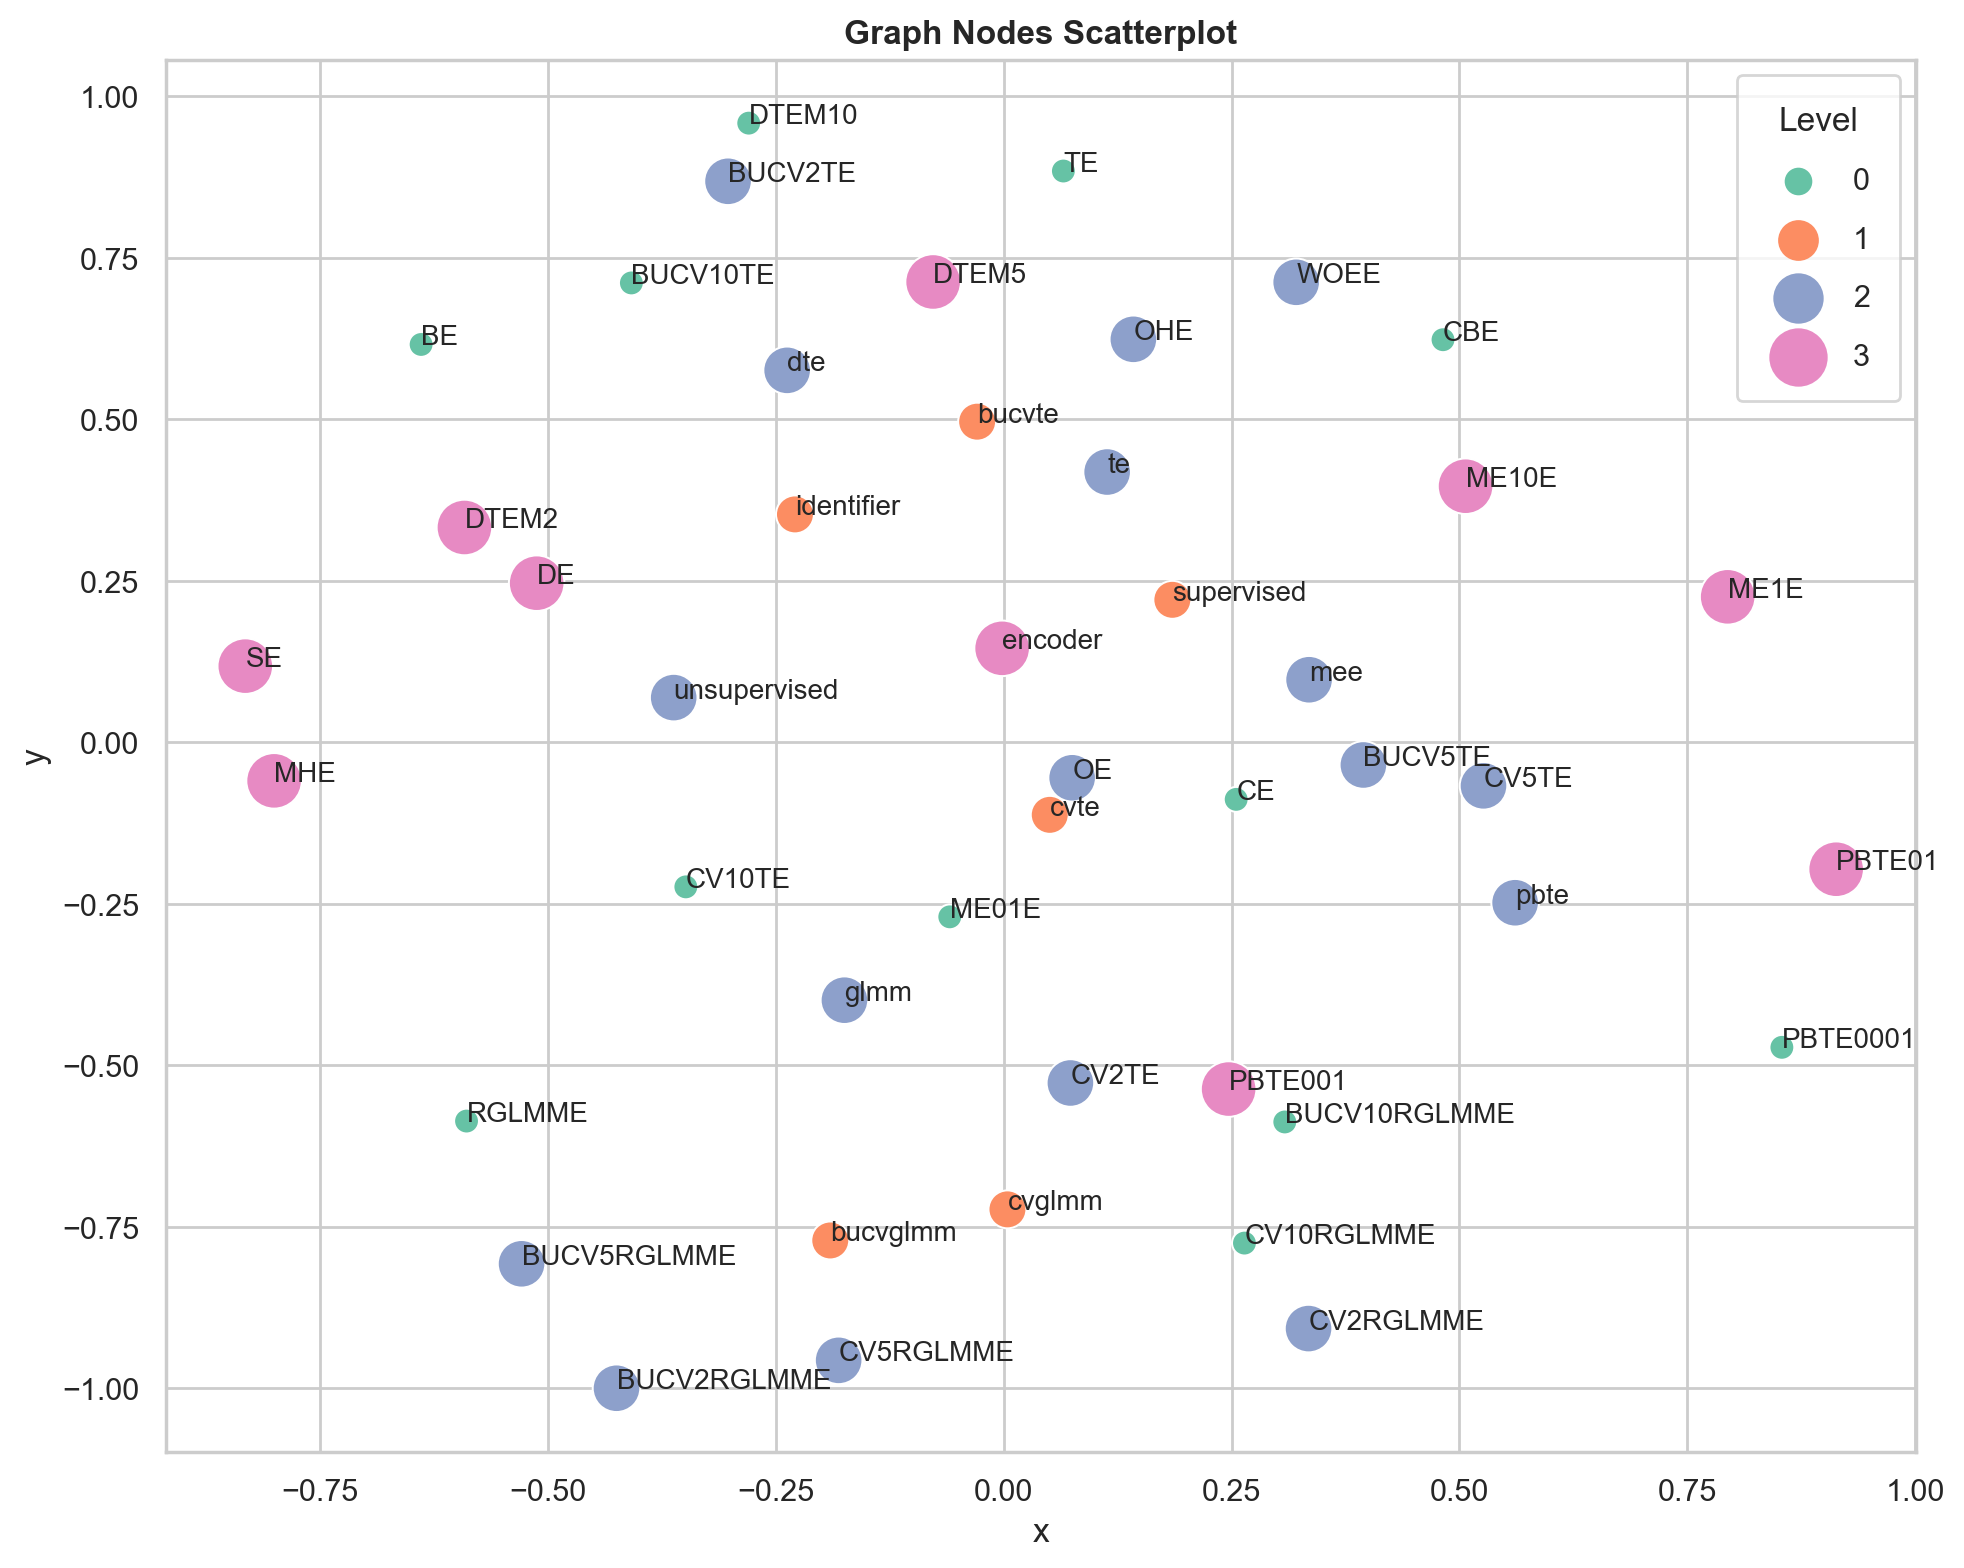

In [12]:
# Make scatter plot of the nodes
plt.figure(figsize=(10, 8))
sns.scatterplot(data=graph_df, x='x', y='y', hue='level', size='level', sizes=(80, 400), palette="Set2")
# Add node labels as annotations to the plot
for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=10)
# Add title to the plot
plt.title('Graph Nodes Scatterplot', fontweight='bold')
# Add legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', title='Level', labelspacing=1.0, borderpad=1)
# Show plot
plt.tight_layout()
plt.show()

# Poincarè embedding
We want to encode the feature encoder using the [Poincarè Embedding](https://radimrehurek.com/gensim/models/poincare.html). By doing this we encode the hierarchical structure of the feature encoder and preserve it. The graph with the hierarchical structure is given in [data/raw](../../data/raw), the library networkx is used to load the graph.

Hierarchies are often trees where the number of nodes increases exponentially by the level, so we want a space that increases exponentially as we deviate from the “origin” of the space. The Poincaré ball follows this property, so we can define our vectors on this space. We define a loss function that gives a good score for clustering vectors in the same hierarchy and spreading out vectors in different hierarchies. Finally, we can find vectors to minimize our loss function using Riemann gradient descent and get a good numerical representation of the words being the name of the encoders.

The method is described in [Maximilian Nickel, Douwe Kiela - “Poincaré Embeddings for Learning Hierarchical Representations”](https://arxiv.org/abs/1705.08039)

In [13]:
%%time
# Extract all relations form the graph
relations = []
for edge in G.edges():
    relations.append((edge[0], edge[1]))

CPU times: total: 0 ns
Wall time: 0 ns


In [55]:
%%time
# Embed the graph
model = PoincareModel(relations, seed=7)
# Train the model
model.train(epochs=1000, print_every=500)

CPU times: total: 2.12 s
Wall time: 4.47 s


In [56]:
# Get the embeddings (vector representation) of the nodes hierarchy structure
embeddings = model.kv.vectors
# Map embeddings (vector representation) to node names
embeddings_dict = {}
for node in G.nodes:
    embeddings_dict[node] = model.kv[node]

In [57]:
# Transform embeddings (vector representation) to a dataframe
embeddings_df = pd.DataFrame(embeddings)
# Add node names as a column to the dataframe
embeddings_df['node'] = embeddings_dict.keys()
embeddings_df = embeddings_df.set_index('node')
# Rename columns to dimension_1, dimension_2, ...
embeddings_df.columns = [f'dimension_{i}' for i in range(1, embeddings_df.shape[1] + 1)]
embeddings_df

,dimension_1,dimension_2,dimension_3,dimension_4,dimension_5,dimension_6,dimension_7,dimension_8,dimension_9,dimension_10,...,dimension_41,dimension_42,dimension_43,dimension_44,dimension_45,dimension_46,dimension_47,dimension_48,dimension_49,dimension_50
node,,,,,,,,,,,,,,,,,,,,,
BE,0.017106,0.092537,0.176654,-0.010546,-0.020859,-0.107515,-0.092081,0.064937,0.127230,0.008844,...,-0.028732,0.106829,-0.029147,0.258056,-0.195058,-0.103590,-0.003693,0.049638,-0.029095,0.290640
identifier,0.016821,0.089364,0.171635,-0.009877,-0.019788,-0.105156,-0.088804,0.062444,0.123638,0.008024,...,-0.027991,0.104023,-0.027913,0.250238,-0.189903,-0.100608,-0.003690,0.048269,-0.027730,0.282074
BUCV10RGLMME,0.016674,0.089872,0.171821,-0.010152,-0.020165,-0.104750,-0.089430,0.062976,0.123746,0.008448,...,-0.027951,0.103967,-0.028241,0.250878,-0.189832,-0.100754,-0.003620,0.048299,-0.028187,0.282575
bucvglmm,0.016739,0.089539,0.171568,-0.010008,-0.019960,-0.104848,-0.089044,0.062660,0.123577,0.008227,...,-0.027950,0.103901,-0.028052,0.250335,-0.189689,-0.100581,-0.003652,0.048232,-0.027929,0.282071
BUCV10TE,0.020641,0.049051,0.139246,0.008055,0.003941,-0.115190,-0.044670,0.022135,0.101039,-0.017339,...,-0.024562,0.093688,-0.005818,0.181030,-0.171194,-0.080881,-0.007720,0.042054,-0.001725,0.213379
bucvte,0.237247,-0.072412,-0.129617,-0.117020,-0.119409,0.110538,0.065273,0.313817,0.093606,0.081133,...,-0.025640,-0.082948,-0.055750,-0.086962,0.163198,0.068524,-0.048647,-0.220731,-0.048921,0.117785
BUCV2RGLMME,0.207989,-0.062286,-0.114417,-0.103081,-0.105894,0.098941,0.056301,0.276951,0.082051,0.072619,...,-0.021946,-0.073208,-0.047670,-0.074681,0.144576,0.059202,-0.041583,-0.193854,-0.043748,0.103088
BUCV2TE,0.203732,-0.060901,-0.112274,-0.101014,-0.103900,0.097130,0.055232,0.271597,0.080403,0.071454,...,-0.021335,-0.071731,-0.046450,-0.072994,0.141822,0.057830,-0.040485,-0.189863,-0.043074,0.100888
BUCV5RGLMME,0.208402,-0.062452,-0.115095,-0.103257,-0.106248,0.099166,0.057019,0.277891,0.082290,0.073292,...,-0.021657,-0.073381,-0.047329,-0.074948,0.145192,0.059017,-0.041212,-0.194110,-0.044268,0.102986


### Visualization & Evaluation

In [58]:
# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=7)
embeddings_2d_tsne = tsne.fit_transform(embeddings_df.values)
embeddings_2d_df_tsne = pd.DataFrame(embeddings_2d_tsne, index=embeddings_df.index, columns=['dimension_1', 'dimension_2'])
embeddings_2d_df_tsne

,dimension_1,dimension_2
node,,
BE,-9.543241,2.213132
identifier,-9.362420,2.053205
BUCV10RGLMME,-9.343409,2.029731
bucvglmm,-9.372871,2.057496
BUCV10TE,-9.710354,1.658005
bucvte,-8.928738,-1.553567
BUCV2RGLMME,-9.015315,-1.447954
BUCV2TE,-9.028884,-1.430887
BUCV5RGLMME,-9.011307,-1.449766


In [ ]:
# Perform dimensionality reduction using PCA
pca = PCA(n_components=2, random_state=7)
embeddings_2d_pca = pca.fit_transform(embeddings_df.values)
embeddings_2d_df_pca = pd.DataFrame(embeddings_2d_pca, index=embeddings_df.index, columns=['dimension_1', 'dimension_2'])
embeddings_2d_df_pca

In [59]:
# Add hierarchical level as a column to the dataframe where node names are the index
embeddings_2d_df_tsne['level'] = nx.get_node_attributes(G, 'hierarchical_level').values()
embeddings_2d_df_tsne

,dimension_1,dimension_2,level
node,,,
BE,-9.543241,2.213132,0
identifier,-9.362420,2.053205,1
BUCV10RGLMME,-9.343409,2.029731,0
bucvglmm,-9.372871,2.057496,1
BUCV10TE,-9.710354,1.658005,0
bucvte,-8.928738,-1.553567,1
BUCV2RGLMME,-9.015315,-1.447954,2
BUCV2TE,-9.028884,-1.430887,2
BUCV5RGLMME,-9.011307,-1.449766,2


In [60]:
# Plot the embedding in an 2D scatter plot with a widget to select the level to plot
def plot_embeddigs(data, levels):
    # filter df
    data_filtered = data[data['level'].isin(levels)]
    # plot
    fig = plt.figure(figsize=(11, 7))
    sns.scatterplot(data=data_filtered, x='dimension_1', y='dimension_2', hue='level', palette="Set2", sizes=(80, 400), size='level')
    # Add node labels as annotations to the plot
    for node, (x, y, level) in data_filtered.iterrows():
        plt.text(x, y, node, fontsize=10)
    # Add title to the plot
    plt.title("Poincaré Embedding with 2D Dimensionality Reduction", fontweight='bold')
    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', title='Level', labelspacing=1.0, borderpad=1)
    # Name axes
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    # Show plot
    plt.tight_layout()
    plt.show()

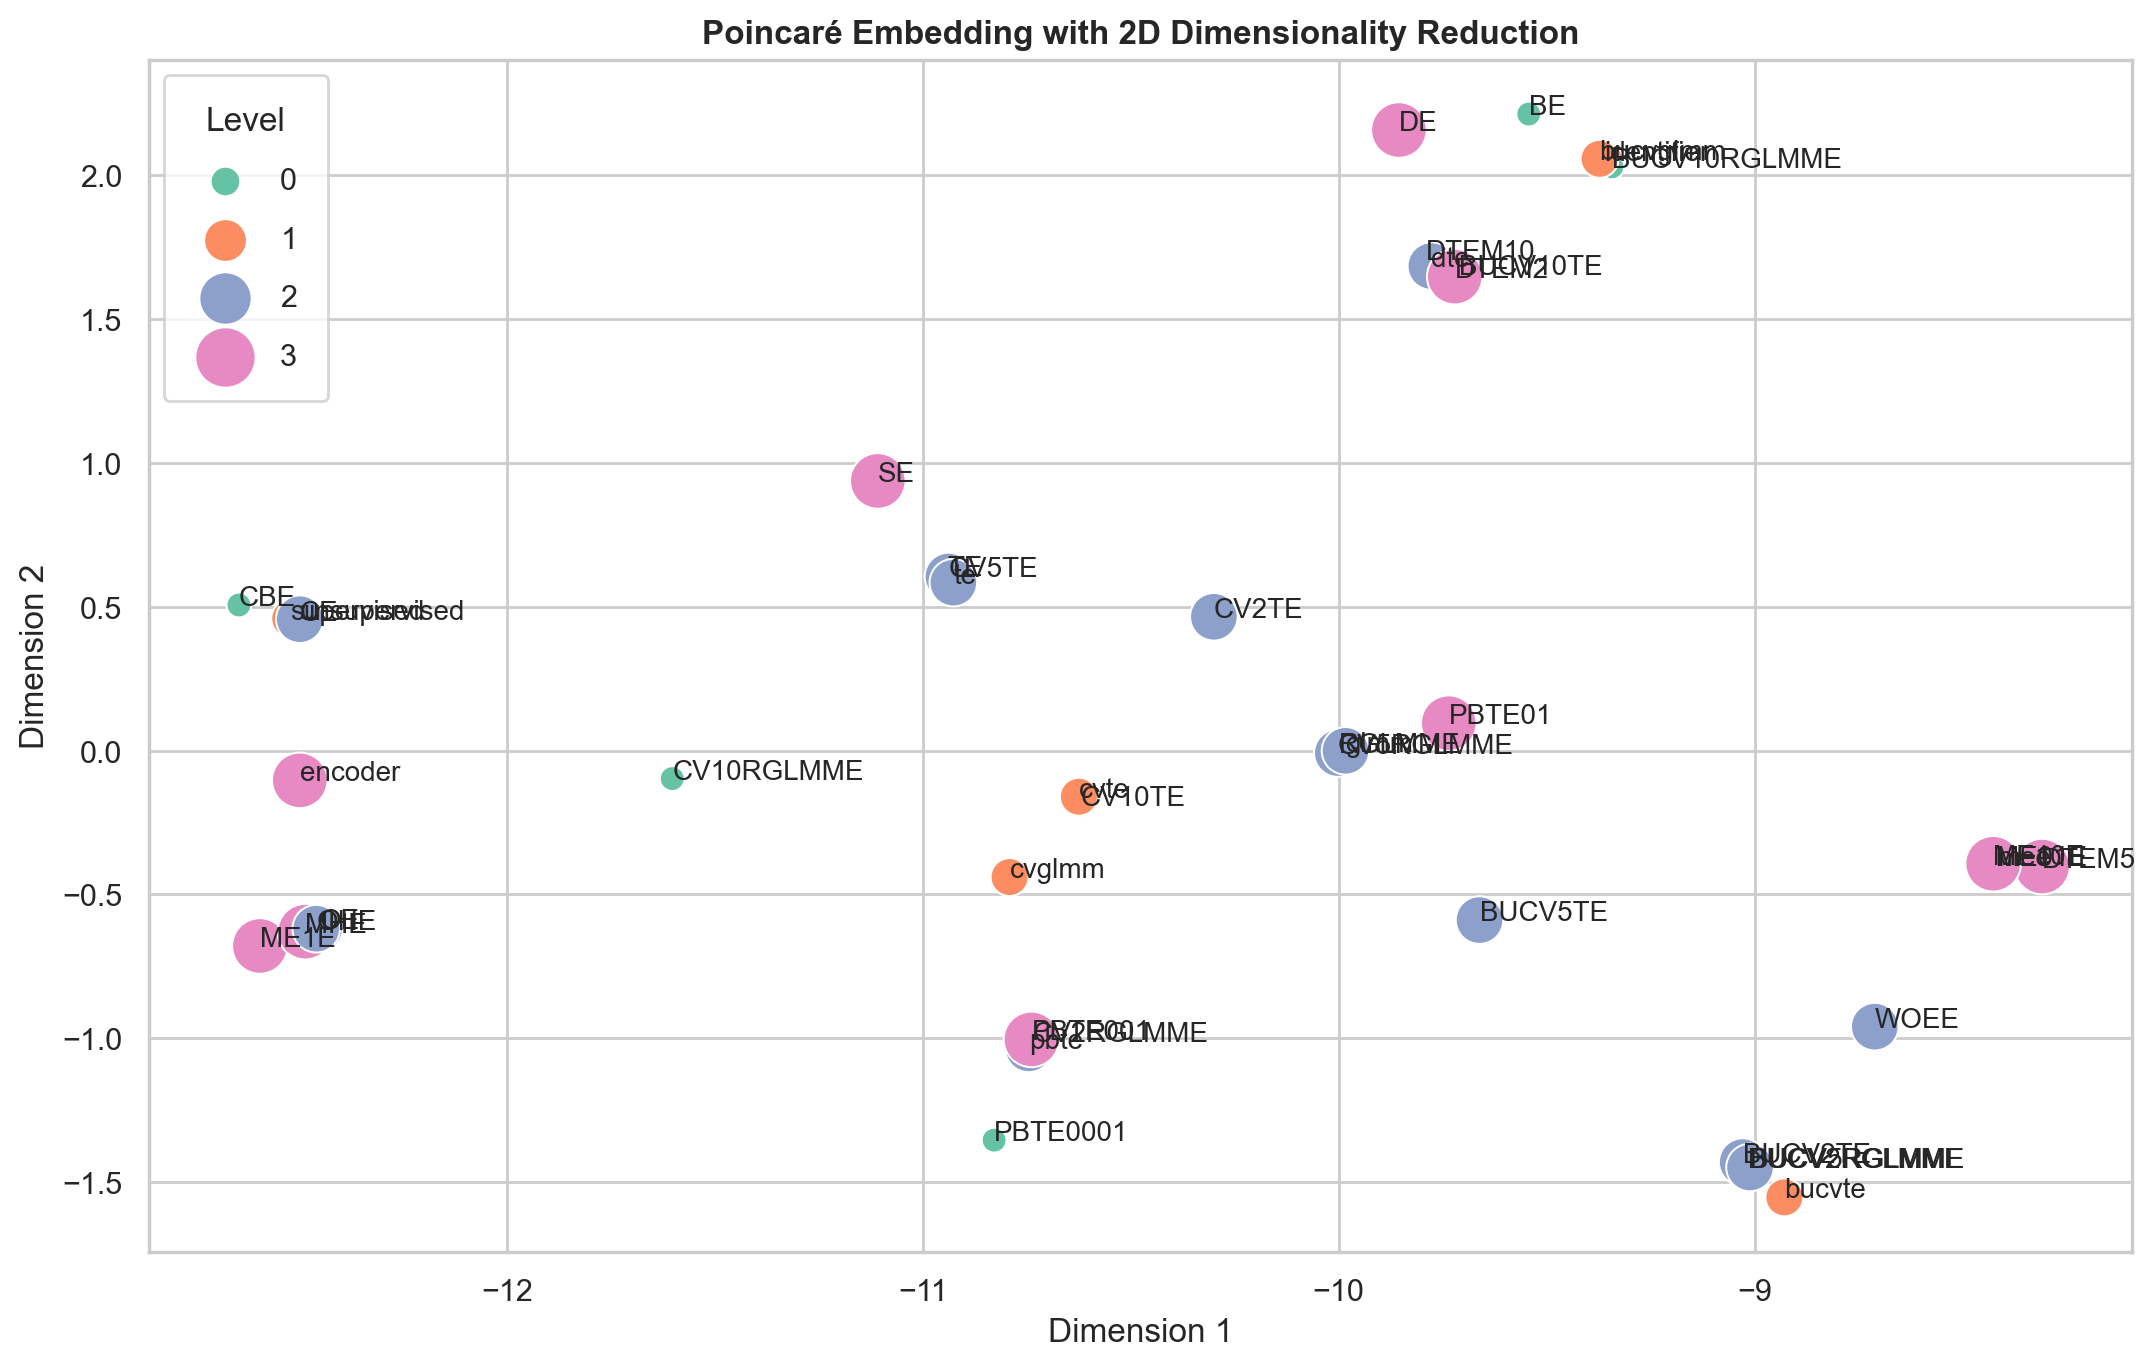

In [61]:
plot_embeddigs([0, 1, 2, 3, 4])

Findings:
* The embedding is not very good, but it is possible to see that the nodes are clustered by their hierarchical level.